# Attempt to reproduce Ma et al. 2020 DBSCAN results on ICESat-2 data

#### Try to reproduce Figs 5,6 and 7 from "Satellite-derived bathymetry using the ICESat-2 lidar and Sentinel-2 imagery datasets" in Remote Sensing of Environment

In [1]:
# Try this? 
#https://www.tandfonline.com/doi/full/10.1080/01431161.2020.1862441?casa_token=bV50wVeWFyoAAAAA%3AOFZG5b1gmbUTM_8Rot-4aZtW0aCR4xYsiI9yI1Cj_GJI7sI4TddXLYunzmPO7CZFtdXZPn-CnM4

import geopandas as gpd
import h5py
import importlib
import json
import lxml
import math
import matplotlib
import numpy as np
import os
import pandas as pd
import pyproj as proj
import rasterio
import requests
import seaborn as sns
import sys
import zipfile
import fiona

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from scipy.stats import pearsonr
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from sklearn.cluster import DBSCAN
from shapely.geometry import Point
from tqdm import tqdm

import ATL03_API as is2api
import Coral_Reef as coral_reef
import Depth_profile as depth
import ICESAT_plots as is2_plot
import IS2_file as is2File
import Pixel_transformation as pt
import Reef_plots as reef_plots
import Sentinel_API as sentinel
import Sentinel2_image as s2_img
import Tide_API as tide
import Water_level as water_level

#!! additional packages I added
import datetime
import pytz
from astropy.time import Time
from astral import LocationInfo
from astral.sun import sun
import matplotlib.pyplot as plt
from pyproj import CRS
from pyproj import Transformer


In [2]:
# set up definitions of pathnames and coordinates

reef_name = 'US_Virgin_Islands'#'Long_Cay' #'Quanfu' #'US_Virgin_Islands' #'Shanhu' #'Quanfu' 

# define path names
base_dir = '/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113'
data_dir = os.path.join(base_dir,'data')
reef_path = os.path.join(data_dir,reef_name)
h5_dir = os.path.join(reef_path,'H5')
outfile_path = os.path.join(reef_path,'Output')
data_cleaning_path = os.path.join(outfile_path,'Data_Cleaning')
icesat_fp = os.path.join(data_cleaning_path,'ICESAT_photons')

# setup coordinate projections
crs_wgs = CRS(4326) # WGS84 geographic
crs_bng = CRS(3857) # CRS with units of meters

# get reef bounding box coords
# loads in geojson of reef into geopandas
geojson_fp = os.path.join(reef_path,reef_name + '.geojson')
reef_gjson = gpd.read_file(geojson_fp)
reef_polygon = reef_gjson.geometry[0]
# get min_lon,min_lat,max_lon,max_lat bounds
coords = reef_polygon.bounds

# get data file names
h5_filenames = [f for f in os.listdir(h5_dir) if not f.startswith('.')]

In [3]:
# x-y rotation function used to convert to along-track coordinate frame
def xyRotate(x,y,theta,**kwargs):
    """
    xyRotate  Rotate data.
    clockwise rotation around origin XO,YO
    [XR YR] = xyRotate(X,Y,THETA) rotates the coordinates X,Y by THETA
    (theta in radians). (Origin does not move, X0 = 0, Y0 = 0)
    OR
    [XR YR] = xyRotate(X,Y,THETA,xo=XO,yo=YO) rotates the coordinates around the
    origin XO,YO.
    Note: Clunky as this is modified from one of my Matlab functions. Find more 'pythonic' way?
    """
    # Default origin is 0,0
    xo = kwargs.get("xo",0)
    yo = kwargs.get("yo",0)
    # Ravel and Translate
    xt = np.ravel(x)-xo
    yt = np.ravel(y)-yo
    # Create xy Matrix of raveled translated data
    xt = xt.reshape(len(xt),1)
    yt = yt.reshape(len(yt),1)
    XYt = np.hstack((xt,yt))
    # Rotation Matrix
    R = np.array([[np.cos(theta), np.sin(theta)],
                  [-np.sin(theta),  np.cos(theta)]])
    # Rotate
    XYr = np.matmul(XYt,R)
    xrlong = XYr[:,0]
    yrlong = XYr[:,1]
    xr = xrlong.reshape(x.shape)
    yr = yrlong.reshape(y.shape)
    return xr, yr

In [4]:
# only 1 h5 file for now. When more files are downloaded will need to create a loop here
h5_fn = h5_filenames[0]
print(h5_fn)

# load in h5 file 
h5 = h5py.File(os.path.join(h5_dir,h5_fn),'r')

# define strong laser indexing based on sc orientation
sc_orient = h5['orbit_info']['sc_orient'][...][0]
if sc_orient == 1:
    strong_beams = ['gt1r', 'gt2r', 'gt3r']
else:
    strong_beams = ['gt1l', 'gt2l', 'gt3l']
# reference GPS time
[tref] = h5.get('ancillary_data/atlas_sdp_gps_epoch')

processed_ATL03_20181122060325_08340107_003_01.h5


/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/US_Virgin_Islands/Output/Data_Cleaning/ICESAT_photons/US_Virgin_Islands_photons_processed_ATL03_20181122060325_08340107_003_01_gt1r.csv

Reading photons from prior csv file for gt1r
2.5
3
3
3
3
3
/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/US_Virgin_Islands/Output/Data_Cleaning/ICESAT_photons/US_Virgin_Islands_photons_processed_ATL03_20181122060325_08340107_003_01_gt2r.csv

Reading photons from prior csv file for gt2r
2.5
3
3
3
3
3
/Users/bonnieludka/Spaceship/IceSAT2/bathymetry_python_20210113/data/US_Virgin_Islands/Output/Data_Cleaning/ICESAT_photons/US_Virgin_Islands_photons_processed_ATL03_20181122060325_08340107_003_01_gt3r.csv

Reading photons from prior csv file for gt3r
2.5
3
3
3
3
3
3
3


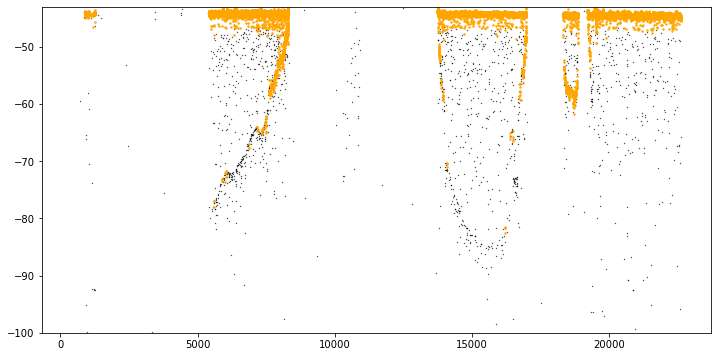

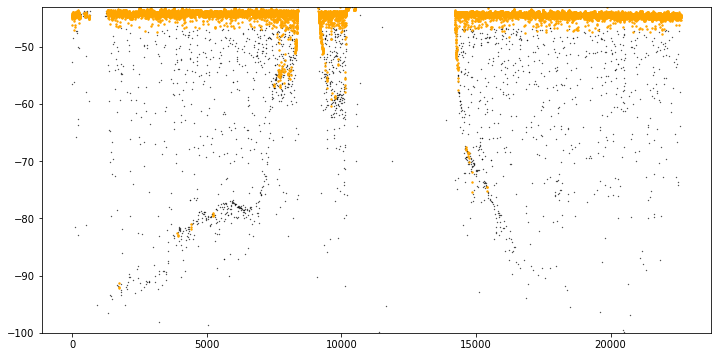

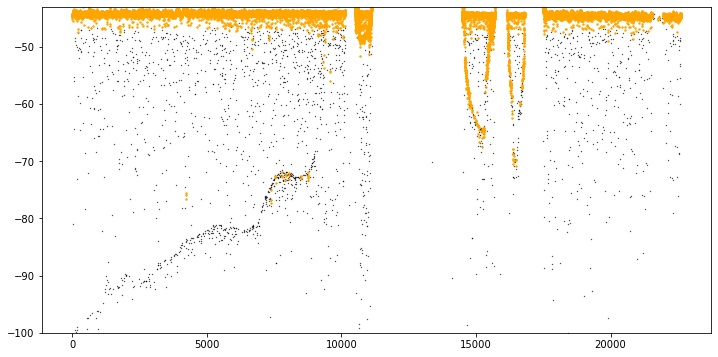

In [5]:
for laser in strong_beams:
    plt.figure(figsize=(12,6))
    # Output directory for csv file containing raw photon data
    photon_fn = '{reef_name}_photons_{h5_fn}_{laser}.csv'.format(reef_name=reef_name, h5_fn=h5_fn.split('.')[0], laser=laser)
    photons_path = os.path.join(icesat_fp, photon_fn)
    print(photons_path)
    
    if not os.path.exists(photons_path):
    
        # load in photon data
        if laser + '/heights/' in h5.keys():
            height = h5.get(laser + '/heights/h_ph')
            lat = h5.get(laser + '/heights/lat_ph')
            lon = h5.get(laser + '/heights/lon_ph')
            conf = h5.get(laser + '/heights/signal_conf_ph')
            confidence = np.array(conf)
            conf_land = confidence[:,0]
            conf_ocean = confidence[:,1]
            conf_inlandwater = confidence[:,3]
            # !!! Added a time column
            dtime = h5.get(laser + '/heights/delta_time') 
            photon_data = [height,lat,lon,conf_land,conf_ocean,conf_inlandwater,dtime]
        else:
            photon_data = []

        if len(photon_data) == 0:
            print('No photons in file for {}'.format(laser))
            continue

        # create dataframe of photon data
        df_laser = pd.DataFrame(photon_data).T
        df_laser.columns = ['Height','Latitude','Longitude','Conf_land','Conf_ocean','Conf_inlandwater','dtime']

        # Clip dataframe to locations within the reef bounding box
        min_longitude,min_latitude,max_longitude,max_latitude = coords
        df = pd.DataFrame()
        df = df_laser.loc[(df_laser.Longitude > min_longitude) & (df_laser.Longitude < max_longitude) &\
        (df_laser.Latitude > min_latitude) & (df_laser.Latitude < max_latitude)]
        df.is_copy = None

        #If there are photons in the new clipped dataframe
        if len(df) != 0:  

            # !!! Saving clipped photons in original vertical datum
            # !!! This is different from Sunil-Borsa code, which saves in vert. coord. relative to estimated sea surface

            # !!! also adding x and y coords in the same dataframe

            transformer = Transformer.from_crs(crs_wgs, crs_bng,always_xy=True)
            df.loc[:,'x'],df.loc[:,'y'] =  transformer.transform(df.Longitude.values, df.Latitude.values)
            
            # !!! also adding track-oriented coordinates

            # fit a line to the data
            m, b = np.polyfit(df.x.values, df.y.values, 1)
            # calculate rotation and translation parameters from fit for new track-oriented coords 
            # rotation angle
            theta = -np.arctan(-(1/m))
            # offset such that southernmost point is zero
            y0 = min(df.y.values)
            x0 = (y0-b)/m
            # translate and rotate to along (alg) and cross (crs) track coordinates
            df.loc[:,'crs'], df.loc[:,'alg'] = xyRotate(df.x.values,df.y.values,theta,xo=x0,yo=y0)

            print('Writing photons for clipped dataframe to csv file for {}'.format(laser))
            df.to_csv(photons_path)

        else:
            print('No photons over reef for {}'.format(laser))
            df.to_csv(photons_path)
    else:
        print('\n' + 'Reading photons from prior csv file for {}'.format(laser))
        df = pd.read_csv(photons_path)
        metadata_path = os.path.join(reef_path, 'ICESAT_metadata.json')
        if os.path.exists(metadata_path):
            metadata = json.load(open(metadata_path))
    
    #print(df)
    
    if len(df) != 0: 
        
        # !!!! Ma et al. method for DBSCAN params

        # For this time of day, was it light or dark?

        # When was data collected?
        # just use first lidar datapoint in clipped data to keep it simple
        tGPS = df.dtime.iloc[0]+tref
        t_in = Time(tGPS, format='gps')
        tUTC = Time(t_in, format='datetime', scale='utc')
        tdt_unaware = tUTC.datetime #for some reason does not record time zone when converting to datetime
        tdt = pytz.utc.localize(tdt_unaware) #make datetime aware of time zone here

        # Get sunrise and sunset time in UTC
        l = LocationInfo()
        l.name = reef_name
        l.region = 'world'
        l.timezone = 'UTC'
        l.latitude = df.Latitude.iloc[0]
        l.longitude = df.Longitude.iloc[0]
        s = sun(l.observer, tdt)

        # adjust DBSCAN radius based on time of day of lidar data
        # daytime
        if tdt > s['sunrise'] and tdt < s['sunset']: 
            Ra = 1.5
        ## dawn (Ma et al. don't do this but since this function outputs dawn and dusk we could)
        #elif tdt > s['dawn'] and tdt< s['sunrise']: 
        #    Ra = 2
        ## dusk (Ma et al. don't do this but since this function outputs dawn and dusk we could)
        #elif tdt > s['sunset'] and tdt< s['dusk']: 
        #    Ra = 2
        # nighttime
        else:                                    
            Ra = 2.5
        
        print(Ra)

        # analyze in chunks, ~10,000 points each
        # N1 points in chunk
        N1 = math.ceil(len(df)/round(len(df)/10000))
        for i in range(0, len(df), N1):
            ch = df[i:i+N1]

            # Calculate signal to noise ratios for MinPts dbscan parameter
            h = max(ch.Height) - min(ch.Height)
            l = max(ch.alg)-min(ch.alg)
            SN1 = math.pi*Ra**2*N1/(h*l)

            h2 = 5
            N2 = sum(ch.Height<(min(ch.Height)+5))
            SN2 = math.pi*Ra**2*N2/(h2*l)

            MinPts = (2*SN1 - SN2) / math.log(2*SN1/SN2)
            if MinPts<3:
                MinPts=3
            print(MinPts)

            # set up inputs for dbscan
            z_ch = ch.Height.values
            a_ch = ch.alg.values
            #chop off topography
            if reef_name == 'US_Virgin_Islands':
                a_ch = np.delete(a_ch, np.where(z_ch > -43))
                z_ch = np.delete(z_ch, np.where(z_ch > -43))
            z_ch = z_ch.reshape(len(z_ch),1)
            a_ch = a_ch.reshape(len(a_ch),1)
            za = np.hstack((z_ch, a_ch)) 

            # extract signal using dbscan
            dbscan = DBSCAN(eps = Ra, min_samples = MinPts)

            if len(za) != 0:
                model = dbscan.fit(za)
                labels = model.labels_
                #signal
                a_sig = a_ch[labels >= 0]
                z_sig = z_ch[labels >= 0]
                #noise
                a_ns = a_ch[labels < 0]
                z_ns = z_ch[labels < 0]
            else:
                a_sig = pd.DataFrame()
                z_sig = pd.DataFrame()
                a_ns = pd.DataFrame()
                z_ns = pd.DataFrame()

            plt.scatter(a_ns, z_ns, s = 0.1, color = 'black', label = 'noise')
            plt.scatter(a_sig,z_sig, s= 2, color = 'orange',label = 'signal') 
            if reef_name == 'Long_Cay' and laser == 'gt3l':
                plt.xlim(2750, 4750)
                plt.ylim(-70,-10)
                #plt.ylim(-38 -36)
            if reef_name == 'US_Virgin_Islands':
                plt.ylim(-100, -43)
        

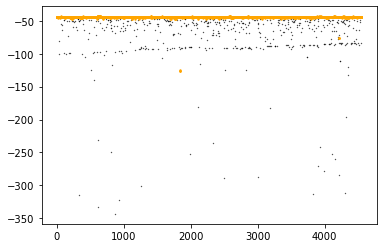

In [6]:

plt.scatter(a_ns, z_ns, s = 0.1, color = 'black', label = 'noise')
plt.scatter(a_sig,z_sig, s= 2, color = 'orange',label = 'signal') 

#if reef_name == 'US_Virgin_Islands':
#     #plt.ylim(-4, 4)
     #plt.xlim(8000,10000)
#     plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
#     plt.ylabel('Elevation rel. MSL [m]', fontsize=16)
    

Text(0, 0.5, 'Elevation rel. MSL [m]')

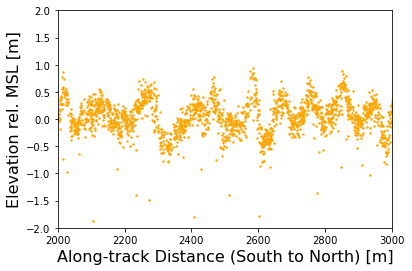

In [17]:
plt.scatter(a_ns, z_ns, s = 0.1, color = 'black', label = 'noise')
plt.scatter(a_sig,z_sig+44.25, s= 2, color = 'orange',label = 'signal') 
plt.ylim(-2, 2)
plt.xlim(2000,3000)
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Elevation rel. MSL [m]', fontsize=16)

Text(0, 0.5, 'Elevation rel. MSL [m]')

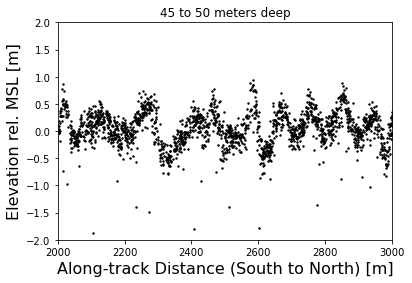

In [40]:

plt.scatter(df.alg,df.Height+44.25,s = 2, color = 'black')
plt.ylim(-2, 2)
plt.xlim(2000,3000)
plt.title('45 to 50 meters deep')
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Elevation rel. MSL [m]', fontsize=16)

Text(0, 0.5, 'Elevation rel. MSL [m]')

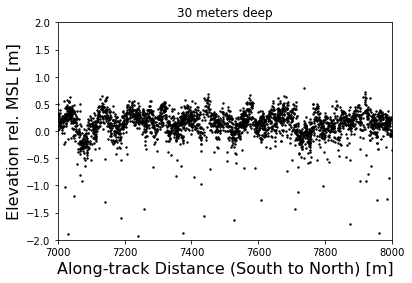

In [41]:
plt.scatter(df.alg,df.Height+44.25,s = 2, color = 'black')
plt.ylim(-2, 2)
plt.xlim(7000,8000)
plt.title('30 meters deep')
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Elevation rel. MSL [m]', fontsize=16)

Text(0, 0.5, 'Elevation rel. MSL [m]')

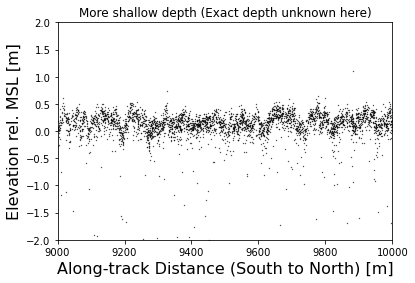

In [37]:
plt.scatter(df.alg,df.Height+44.25,s = 0.1, color = 'black')
plt.ylim(-2, 2)
plt.xlim(9000,10000)
plt.title('More shallow depth (Exact depth unknown here)')
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Elevation rel. MSL [m]', fontsize=16)

Text(0, 0.5, 'Elevation rel. MSL [m]')

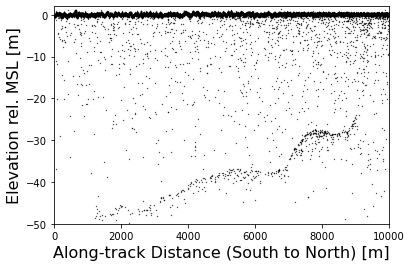

In [39]:
plt.scatter(df.alg,df.Height+44.25,s = 0.1, color = 'black')
plt.ylim(-50, 2)
plt.xlim(0,10000)
plt.xlabel('Along-track Distance (South to North) [m]', fontsize=16)
plt.ylabel('Elevation rel. MSL [m]', fontsize=16)

In [43]:
#deep
lam = 100
per = (lam*2*math.pi/9.8)**0.5
print(per)




8.007130309139898


In [45]:
(7.930*10**6)-(7.928*10**6)

2000.0